In [62]:
import pandas as pd
from tqdm import tqdm
from hopfield import *

In [63]:
# n nodes
# k images
# see if the images are fixed pts (not necessarily stable)
max_num_nodes_to_test = 100
remembrance_threshold = 0.0 # demical /percentage
number_of_trials_per_num_nodes = 100

In [64]:
def check_remembrance(network: Hopfield, image: np.array):
    network.values = image
    updated_values = network.do_synchronous_update()
    hamming_distance = network.hamming_distance(updated_values, image)
    try:
        assert hamming_distance <= int(remembrance_threshold * network.n)
        return True
    except AssertionError:
        # print(hamming_distance)
        return False

In [65]:
def check_multiple_remembrances(network: Hopfield, images: list[np.array]):
    for image in images:
        if not check_remembrance(network, image):
            return False
    return True

In [66]:
def find_how_many_images_network_can_store_with_n_nodes(n: int):
    remembrance_data = []
    network = Hopfield(shape = (n, 1))
    network.train_on_values()
    images_trained_on = [np.array(network.values)]
    remembrance_data.append(check_multiple_remembrances(network, images_trained_on))

    while remembrance_data[-1] is True:
        random_image = network.generate_random_image()
        network.train_on_new(random_image)
        images_trained_on.append(random_image)
        remembrance_data.append(check_multiple_remembrances(network, images_trained_on))

    return len(remembrance_data) - 1

In [67]:
num_images_remembered = {n: [] for n in range(2, max_num_nodes_to_test + 1)}

for n in tqdm(range(2, max_num_nodes_to_test + 1)):
    for _ in range(number_of_trials_per_num_nodes):
        num_images_remembered[n].append(find_how_many_images_network_can_store_with_n_nodes(n))

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [05:56<00:00,  3.61s/it]


<Axes: title={'center': '100 iterations per number of nodes | Absolute memory threshold | Hebbian learning'}, xlabel='Number of Nodes', ylabel='No. of Images Remembered'>

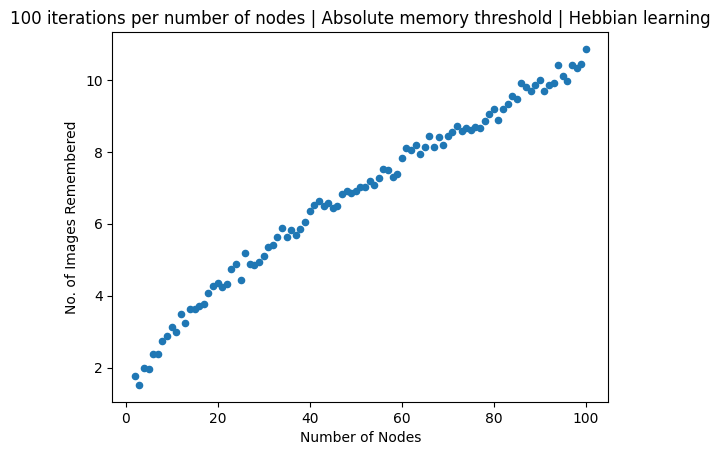

In [68]:
interpreted_data = {"No. of Images Remembered": [sum(num_images_remembered[n]) / len(num_images_remembered[n]) for n in num_images_remembered.keys()], "Number of Nodes": [n for n in num_images_remembered.keys()]}
dataframe = pd.DataFrame(interpreted_data)

fit = np.polyfit(pd.to_numeric(interpreted_data["Number of Nodes"]), pd.to_numeric(interpreted_data["No. of Images Remembered"]), 1)
line = np.poly1d(fit)
dataframe.insert(1, "Linear Regression", line(pd.to_numeric(interpreted_data["Number of Nodes"])))
# print(interpreted_data)
# print(dataframe)
fit = np.polyfit(pd.to_numeric(dataframe["Number of Nodes"] / (2 * np.log2(dataframe["Number of Nodes"]))), pd.to_numeric(dataframe["No. of Images Remembered"]), 1)
line = np.poly1d(fit)
dataframe.insert(1, "n / 2 * log2(n)", line(pd.to_numeric(dataframe["Number of Nodes"] / (2 * np.log2(dataframe["Number of Nodes"])))))
dataframe.plot(x="Number of Nodes", y="No. of Images Remembered", kind="scatter", title=str(number_of_trials_per_num_nodes) + " iterations per number of nodes | Absolute memory threshold | Hebbian learning")
# ax = dataframe.plot(x="Number of Nodes", y="Linear Regression", ax=ax, color="Red")
# dataframe.plot(x="Number of Nodes", y="n / 2 * log2(n)", ax=ax, color="Green")


In [69]:
dataframe["Number of Nodes"] / (2 * np.log2(dataframe["Number of Nodes"]))

0     1.000000
1     0.946395
2     1.000000
3     1.076691
4     1.160558
        ...   
94    7.289335
95    7.348582
96    7.407732
97    7.466788
98    7.525750
Name: Number of Nodes, Length: 99, dtype: float64